In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.climate_emulator import Climate_Emulator
from teslakit.extremes import Peaks_Over_Threshold as POT
from teslakit.util.time_operations import xds_reindex_daily

from teslakit.mda import MaxDiss_Simplified_NoThreshold



C:\Users\lcag075\AppData\Local\Continuum\anaconda2\envs\teslakit\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# --------------------------------------
# Teslakit database

p_data = r'C:\Users\lcag075\Dropbox\MAJURO-teslakit\teslakit\DATA'
db = Database(p_data)

# set site
db.SetSite('MAJURO')

# MDA number of cases
num_sel_mda = 500

In [3]:
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)

for a in range (5):
    if a==0:
        WVS_sim, tc_sim, WVS_upd1 = CE.LoadSim(n_sim = a)
        WVS_SIM=WVS_sim.sel(n_sim=0)
    else:
        WVS_sim, tc_sim, WVS_upd1 = CE.LoadSim(n_sim = a)
        WVS_SIM=xr.concat([WVS_SIM, WVS_sim.sel(n_sim=0)], dim='sim')
            

In [4]:
WVS_SIM.to_netcdf(op.join(p_data, 'sites' ,'MAJURO','Simulated_max_storm_values.nc'))

In [5]:
# --------------------------------------
# Load complete hourly data for extremes analysis

# Historical
# WVS = db.Load_WAVES_hist()

CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
# Simulation

HS=[]; H1=[]; H2=[]; H3=[]
TS=[]; T1=[]; T2=[]; T3=[]
DS=[]; D1=[]; D2=[]; D3=[]
MSL=[]; WD=[]; WS=[]
for a in range (5):
    WVS_sim, tc_sim, WVS_upd1 = CE.LoadSim(n_sim = a)
    HS=np.append(HS,WVS_sim.sea_Hs); H1=np.append(H1,WVS_sim.swell_1_Hs); H2=np.append(H2,WVS_sim.swell_2_Hs); H3=np.append(H3,WVS_sim.swell_3_Hs)
    TS=np.append(TS,WVS_sim.sea_Tp); T1=np.append(T1,WVS_sim.swell_1_Tp); T2=np.append(T2,WVS_sim.swell_2_Tp); T3=np.append(T3,WVS_sim.swell_3_Tp);
    DS=np.append(DS,WVS_sim.sea_Dir); D1=np.append(D1,WVS_sim.swell_1_Dir); D2=np.append(D2,WVS_sim.swell_2_Dir); D3=np.append(D3,WVS_sim.swell_3_Dir);
    MSL=np.append(MSL, WVS_sim.msl); WD=np.append(WD,WVS_sim.wind_dir);  WS=np.append(WS,WVS_sim.wind_speed); 

In [6]:
WVS_sim

<xarray.Dataset>
Dimensions:      (n_sim: 1, time: 85288)
Coordinates:
  * time         (time) object 2000-01-01 00:00:00 ... 3000-01-01 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    DWT          (n_sim, time) float32 ...
    sea_Hs       (n_sim, time) float32 2.5052252 3.0372937 ... 2.46155 2.5100558
    sea_Tp       (n_sim, time) float32 10.056094 7.882137 ... 10.476686 8.810353
    sea_Dir      (n_sim, time) float32 52.22437 68.45873 ... 60.57043 50.603596
    swell_1_Hs   (n_sim, time) float32 0.98428303 0.4324374 ... 0.51102316
    swell_1_Tp   (n_sim, time) float32 10.874669 8.125511 ... 9.801796 5.9136605
    swell_1_Dir  (n_sim, time) float32 337.55966 344.88315 ... 9.576112
    swell_2_Hs   (n_sim, time) float32 0.06103699 0.21428326 ... 0.26421702
    swell_2_Tp   (n_sim, time) float32 8.938288 10.466656 ... 11.922604
    swell_2_Dir  (n_sim, time) float32 83.98466 113.79354 ... 105.999886
    swell_3_Hs   (n_sim, time) float32 0.5525208 0.14235003 ... 0.67424715
    swell_3_Tp   (n_sim, time) float32 8.902455 9.884526 ... 13.052075 8.930893
    swell_3_Dir  (n_sim, time) float32 196.08963 145.78404 ... 177.15216
    wind_speed   (n_sim, time) float32 7.2315636 12.278206 ... 5.363989 9.097131
    wind_dir     (n_sim, time) float32 110.62999 62.273777 ... 72.643265
    msl          (n_sim, time) float32 100696.77 100820.27 ... 100857.51

In [7]:
# --------------------------------------
# MaxDiss classification

# subset, scalar and directional indexes
data_mda = np.column_stack((HS,H1,H2,H3,TS,T1,T2,T3,DS,D1,D2,D3,MSL,WD,WS))
ix_scalar = [0,1,2,3,4,5,6,7,12,14]
ix_directional = [8,9,10,11,13]


In [8]:
data_sim =  xr.Dataset(
    {
        'sea_Hs':(('storm'), data_mda[:,0]),
        'swell_1_Hs':(('storm'), data_mda[:,1]),
        'swell_2_Hs':(('storm'), data_mda[:,2]),
        'swell_3_Hs':(('storm'), data_mda[:,3]),
        'sea_Tp':(('storm'), data_mda[:,4]),
        'swell_1_Tp':(('storm'), data_mda[:,5]),
        'swell_2_Tp':(('storm'), data_mda[:,6]),
        'swell_3_Tp':(('storm'), data_mda[:,7]),
        'sea_Dir':(('storm'), data_mda[:,8]),
        'swell_1_Dir':(('storm'), data_mda[:,9]),
        'swell_2_Dir':(('storm'), data_mda[:,10]),
        'swell_3_Dir':(('storm'), data_mda[:,11]),
        'msl':(('storm'), data_mda[:,12]),
        'wind_dir':(('storm'), data_mda[:,13]),
        'wind_speed':(('storm'), data_mda[:,14]),
        
    },
    coords = {
        'storm':(('storm'), np.arange(len(data_mda)))    
    },
)

print(data_sim)

<xarray.Dataset>
Dimensions:      (storm: 425893)
Coordinates:
  * storm        (storm) int32 0 1 2 3 4 ... 425888 425889 425890 425891 425892
Data variables:
    sea_Hs       (storm) float64 2.193 1.794 1.642 1.805 ... 1.328 2.462 2.51
    swell_1_Hs   (storm) float64 0.6934 1.443 0.7035 ... 0.276 0.3603 0.511
    swell_2_Hs   (storm) float64 0.1082 0.5393 0.4536 ... 0.4564 0.2655 0.2642
    swell_3_Hs   (storm) float64 0.5897 0.2349 0.4635 ... 0.6694 1.452 0.6742
    sea_Tp       (storm) float64 8.381 8.965 9.254 9.282 ... 8.741 10.48 8.81
    swell_1_Tp   (storm) float64 10.61 11.27 10.85 10.97 ... 11.21 9.802 5.914
    swell_2_Tp   (storm) float64 10.6 11.21 9.745 13.83 ... 9.93 10.58 11.92
    swell_3_Tp   (storm) float64 9.244 8.846 10.27 12.56 ... 14.61 13.05 8.931
    sea_Dir      (storm) float64 67.58 98.3 53.71 56.75 ... 75.63 60.57 50.6
    swell_1_Dir  (storm) float64 11.85 6.571 338.5 318.8 ... 326.3 358.6 9.576
    swell_2_Dir  (storm) float64 113.7 126.9 125.5 95.79 ... 

In [9]:
# MDA
centroids = MaxDiss_Simplified_NoThreshold(
    data_mda, num_sel_mda, ix_scalar, ix_directional 
)



MaxDiss waves parameters: 425893 --> 500

   MDA centroids: 500/500



In [10]:
centroids

array([[4.01966858e+00, 5.52856922e-01, 6.62760660e-02, ...,
        1.00751242e+05, 6.68968048e+01, 1.30984926e+01],
       [2.32468769e-01, 5.34496844e-01, 9.75040197e-01, ...,
        1.00702898e+05, 2.43948959e+02, 3.56117249e+00],
       [1.18346751e-01, 4.67515326e+00, 4.93240982e-01, ...,
        1.01088367e+05, 7.74587708e+01, 2.90089726e-01],
       ...,
       [1.98203266e+00, 5.53388357e-01, 3.02101851e-01, ...,
        1.00812141e+05, 2.21129593e+02, 5.50193071e+00],
       [1.93583083e+00, 4.55816555e+00, 9.23850954e-01, ...,
        1.00724844e+05, 3.64408493e+01, 7.48644257e+00],
       [3.56384039e-01, 1.01331186e+00, 7.81447291e-01, ...,
        1.01161695e+05, 5.85952797e+01, 1.26589847e+00]])

In [11]:
# store MDA storms - parameters 
MDA_params = xr.Dataset(
    {
        'sea_Hs':(('storm'), centroids[:,0]),
        'swell_1_Hs':(('storm'), centroids[:,1]),
        'swell_2_Hs':(('storm'), centroids[:,2]),
        'swell_3_Hs':(('storm'), centroids[:,3]),
        'sea_Tp':(('storm'), centroids[:,4]),
        'swell_1_Tp':(('storm'), centroids[:,5]),
        'swell_2_Tp':(('storm'), centroids[:,6]),
        'swell_3_Tp':(('storm'), centroids[:,7]),
        'sea_Dir':(('storm'), centroids[:,8]),
        'swell_1_Dir':(('storm'), centroids[:,9]),
        'swell_2_Dir':(('storm'), centroids[:,10]),
        'swell_3_Dir':(('storm'), centroids[:,11]),
        'msl':(('storm'), centroids[:,12]),
        'wind_dir':(('storm'), centroids[:,13]),
        'wind_speed':(('storm'), centroids[:,14]),
        
    },
    coords = {
        'storm':(('storm'), np.arange(num_sel_mda))    
    },
)

MDA_params.to_netcdf(op.join(p_data, 'sites' ,'MAJURO','MDA_Selection_500_5simsmaxstorm.nc'))

In [12]:
CE.Load()
HIST=CE.WVS_MS
HIST

<xarray.Dataset>
Dimensions:      (time: 3140)
Coordinates:
  * time         (time) datetime64[ns] 1980-02-04T13:00:00 ... 2018-12-31
    station      int32 ...
    longitude    float32 ...
    latitude     float32 ...
Data variables:
    sea_Hs       (time) float64 ...
    sea_Tp       (time) float64 ...
    sea_Dir      (time) float64 ...
    swell_1_Hs   (time) float64 ...
    swell_1_Tp   (time) float64 ...
    swell_1_Dir  (time) float64 ...
    swell_2_Hs   (time) float64 ...
    swell_2_Tp   (time) float64 ...
    swell_2_Dir  (time) float64 ...
    swell_3_Hs   (time) float64 ...
    swell_3_Tp   (time) float64 ...
    swell_3_Dir  (time) float64 ...
    Hs           (time) float64 ...
    Tp           (time) float64 ...
    Dir          (time) float64 ...
    TC_category  (time) float64 ...
    wind_speed   (time) float32 ...
    wind_dir     (time) float32 ...
    msl          (time) float32 ...
    AWL          (time) float64 ...
Attributes:
    source:   teslakit_v0.9.1

In [13]:
def axplot_scatter_params(ax, x_hist, y_hist, x_sim, y_sim):
    'axes scatter plot variable1 vs variable2 historical and simulated'

    # simulated params 
    ax.scatter(
        x_sim, y_sim,
        c = 'silver',
        s = 2,
    )

    # historical params 
    ax.scatter(
        x_hist, y_hist,
        c = 'purple',
        s = 1,
    )


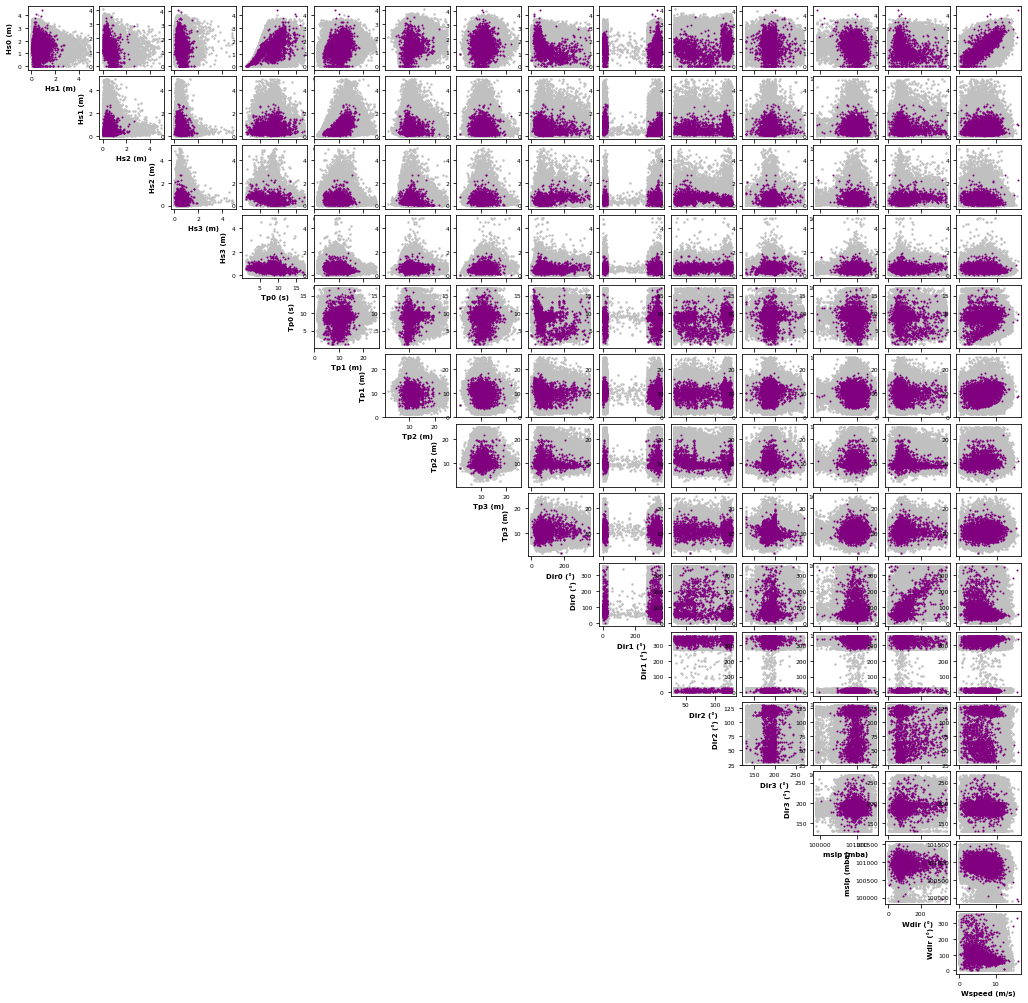

In [14]:
# common fig parameters
_faspect = 1.618
_fsize = 11
_fdpi = 128

'''
Plot scatter with historical vs simulated parameters
'''

# figure conf.
d_lab = {
    'sea_Hs': 'Hs0 (m)',
    'swell_1_Hs': 'Hs1 (m)',
    'swell_2_Hs': 'Hs2 (m)',
    'swell_3_Hs': 'Hs3 (m)',
    'sea_Tp': 'Tp0 (s)',
    'swell_1_Tp': 'Tp1 (m)',
    'swell_2_Tp': 'Tp2 (m)',
    'swell_3_Tp': 'Tp3 (m)',
    'sea_Dir': 'Dir0 (°)',
    'swell_1_Dir': 'Dir1 (°)',
    'swell_2_Dir': 'Dir2 (°)',
    'swell_3_Dir': 'Dir3 (°)',
    'msl': 'mslp (mba)',
    'wind_dir': 'Wdir (°)',
    'wind_speed': 'Wspeed (m/s)',
}

# variables to plot
vns = [ 'sea_Hs','swell_1_Hs','swell_2_Hs','swell_3_Hs','sea_Tp','swell_1_Tp','swell_2_Tp',
        'swell_3_Tp','sea_Dir','swell_1_Dir','swell_2_Dir','swell_3_Dir','msl','wind_dir','wind_speed']
n = len(vns)

# figure
fig = plt.figure(figsize=(_faspect*_fsize, _faspect*_fsize))
gs = gridspec.GridSpec(n-1, n-1, wspace=0.1, hspace=0.1)

for i in range(n):
       for j in range(i+1, n):

            # get variables to plot
            vn1 = vns[i]
            vn2 = vns[j]

            # historical and simulated
            vvh1 = HIST[vn1].values[:]
            vvh2 = HIST[vn2].values[:]

            vvs1 = data_sim[vn1].values[:]
            vvs2 = data_sim[vn2].values[:]

            # scatter plot 
            ax = plt.subplot(gs[i, j-1])
            axplot_scatter_params(ax, vvh2, vvh1, vvs2, vvs1)
            ax.tick_params(axis='both', which='major', labelsize=6)

            # custom labels
            if j==i+1:
                ax.set_xlabel(
                    d_lab[vn2],
                    {'fontsize':7, 'fontweight':'bold'}
                )
            if j==i+1:
                ax.set_ylabel(
                    d_lab[vn1],
                    {'fontsize':7, 'fontweight':'bold'}
                )

plt.show()

In [15]:
def axplot_scatter_params(ax, x_hist, y_hist, x_sim, y_sim):
    'axes scatter plot variable1 vs variable2 historical and simulated'

    # simulated params 
    ax.scatter(
        x_sim, y_sim,
        c = 'silver',
        s = 2,
    )

    # historical params 
    ax.scatter(
        x_hist, y_hist,
        c = 'royalblue',
        s = 1,
    )

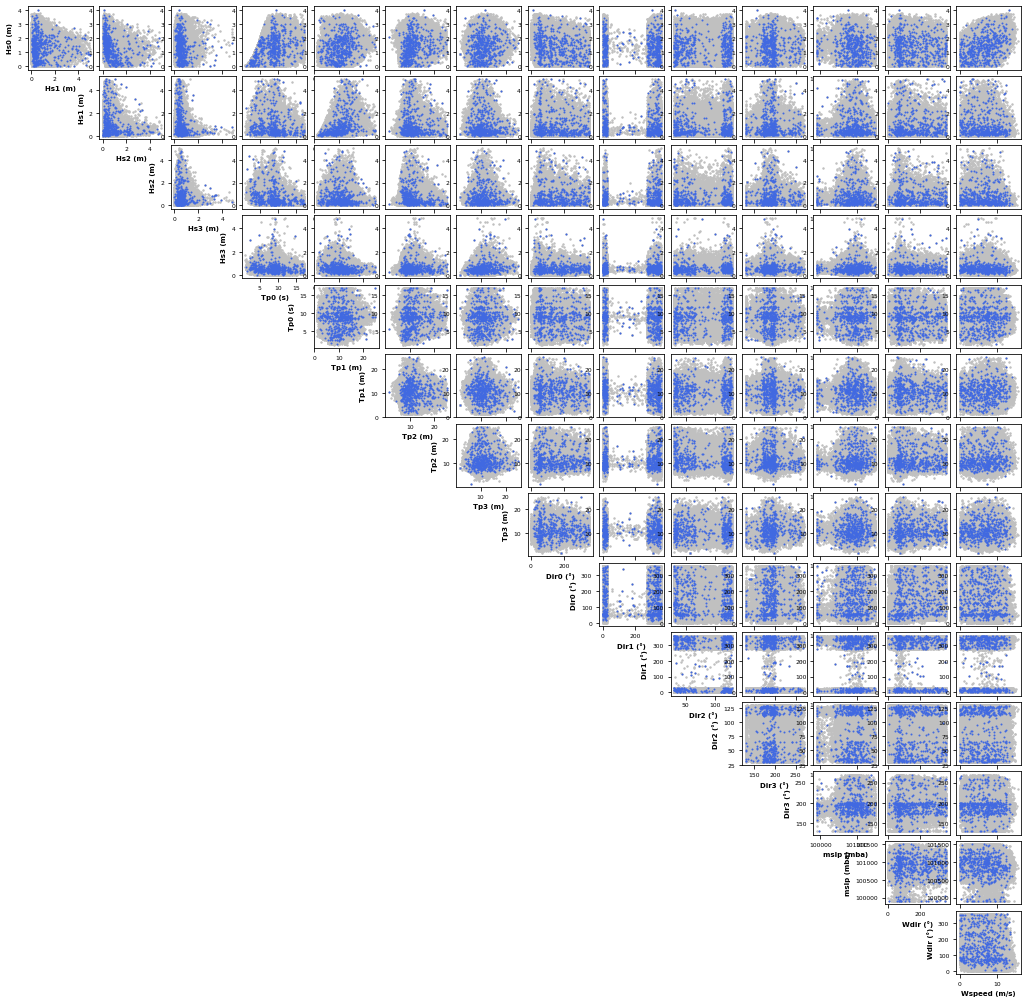

In [16]:
# common fig parameters
_faspect = 1.618
_fsize = 11
_fdpi = 128

'''
Plot scatter with historical vs simulated parameters
'''

# figure conf.
d_lab = {
    'sea_Hs': 'Hs0 (m)',
    'swell_1_Hs': 'Hs1 (m)',
    'swell_2_Hs': 'Hs2 (m)',
    'swell_3_Hs': 'Hs3 (m)',
    'sea_Tp': 'Tp0 (s)',
    'swell_1_Tp': 'Tp1 (m)',
    'swell_2_Tp': 'Tp2 (m)',
    'swell_3_Tp': 'Tp3 (m)',
    'sea_Dir': 'Dir0 (°)',
    'swell_1_Dir': 'Dir1 (°)',
    'swell_2_Dir': 'Dir2 (°)',
    'swell_3_Dir': 'Dir3 (°)',
    'msl': 'mslp (mba)',
    'wind_dir': 'Wdir (°)',
    'wind_speed': 'Wspeed (m/s)',
}

# variables to plot
vns = [ 'sea_Hs','swell_1_Hs','swell_2_Hs','swell_3_Hs','sea_Tp','swell_1_Tp','swell_2_Tp',
        'swell_3_Tp','sea_Dir','swell_1_Dir','swell_2_Dir','swell_3_Dir','msl','wind_dir','wind_speed']
n = len(vns)

# figure
fig = plt.figure(figsize=(_faspect*_fsize, _faspect*_fsize))
gs = gridspec.GridSpec(n-1, n-1, wspace=0.1, hspace=0.1)

for i in range(n):
       for j in range(i+1, n):

            # get variables to plot
            vn1 = vns[i]
            vn2 = vns[j]

            # historical and simulated
            vvh1 = MDA_params[vn1].values[:]
            vvh2 = MDA_params[vn2].values[:]

            vvs1 = data_sim[vn1].values[:]
            vvs2 = data_sim[vn2].values[:]

            # scatter plot 
            ax = plt.subplot(gs[i, j-1])
            axplot_scatter_params(ax, vvh2, vvh1, vvs2, vvs1)
            ax.tick_params(axis='both', which='major', labelsize=6)

            # custom labels
            if j==i+1:
                ax.set_xlabel(
                    d_lab[vn2],
                    {'fontsize':7, 'fontweight':'bold'}
                )
            if j==i+1:
                ax.set_ylabel(
                    d_lab[vn1],
                    {'fontsize':7, 'fontweight':'bold'}
                )

plt.show()